# Link Functions, Logistic Regression, and Advanced AB Testing

<center>
  <img src="img/powerful-electrical-discharge-lightning-strike-impact-place-realistic_33099-753.jpg" style="height:900"; />
</center>

In this lesson we're really going to unleash the power of linear models with this generalized linear models. This is the key concept that takes linear models to the next level, and unlocks all the possibilities you'll see not only in this lesson but every single lesson after this.

## Bayesian AB Test
* Revisit the basic Bayesian AB test
* Estimate probability of a potential customer converting


We'll start with the fundamentals a basic AB test in applied example, where you're a data scientist at a video game store.

## AB Testing on Age
* How can we include a continuous variable into our analysis?
* Various approaches
  * And why they don't work

## Generalizing linear models with link functions
* The **most** important concept of this course  
  * The most useful transformation

## "A Infinite Testing" with Generalized Linear Models
* Use our generalized linear modeling capability to incorporate age

## Case Study: U.S.A. Election Voting
* How does voter preference change with age and party

In this last section you'll leave the video game store get a new job as a political consultant. We'll be analyzing a real dataset about US election preferences using all the things we've learned

In [101]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import statsmodels

from bambi import plots as bmb_plots
from scipy import special
from scipy import stats

plt.style.use("intuitivebayes.mplstyle")
FIGSIZE = (24, 12)
SEED = 0

rng = np.random.default_rng(SEED)

# Hidden Section: Generate data
**Hello students**

Welcome to the hidden section where we generate the data. We've included this in the notebook purposefully so you can use it to aid your learnings. Simulation is an important tool because

* During learning you can create new scenarios to have an infinite amount of practice data
* During EDA you can use simulation to see what functions most closely match the observed data
* Check if your models are correctly specified, especially complex models, by simulating data and seeing if you can recover the parameters



In [102]:
n_samples = 1000

# 1 indicates likes videogames
likes_videogames_bool = stats.bernoulli(p=0.5).rvs(n_samples)
like_videogames_categorical = ["Yes" if obs == 1 else "No" for obs in likes_videogames_bool]

# Age
age = stats.randint(low=18, high=60).rvs(n_samples).astype(float)

df = pd.DataFrame(
    {
        "age": age,
        "likes_videogames": like_videogames_categorical,
        "likes_videogames_bool": likes_videogames_bool,
    }
).sort_values("age")
df.head()

,age,likes_videogames,likes_videogames_bool
387,18.0,Yes,1
179,18.0,Yes,1
786,18.0,No,0
478,18.0,No,0
795,18.0,No,0


## Simulate our data

To simulate our data we're going to make usage of the sigmoid function. This is a very nice function that maps any value to the (0, 1) interval, and it's exactly what we need for probabilities. Unfortunately there are differing names for the sigmoid function. In particular:

* sigmoid
* logistic (or logistic sigmoid)
* expit

Scipy uses the name expit. Since we use Scipy in this course we'll use their naming so you learn both.

In [103]:
special.expit(3)

0.9525741268224334

Now we simulate conversion probabilities and conversion indicators. To do so, we set true parameter values, compute a quantity called the linear predictor (you'll see this all over the course!), map the linear predictor to a probability using the sigmoid function, and then finally obtain the conversion indicators. All of this is then appended to the data frame we started to build a couple of cells above.

In [104]:
# True parameter values
intercept = 1
coeff_age = -0.1
coeff_likes_videogames = 2

# First, create the linear predictor
y = intercept + coeff_age * df["age"] + coeff_likes_videogames * df["likes_videogames_bool"]

# Add small noise, so it's more realistic
y += stats.norm(scale=0.15).rvs(size=len(y), random_state=rng)

# Then, transform it into the probability with the expit function
p_convert = special.expit(y)

# Use the probabilities in `p_convert` to simulated conversion values.
# Remember a prob of 0.99 doesn't guarantee someone will convert!
converted_bool = stats.bernoulli(p=p_convert).rvs(random_state=rng)

# Append columns to our data frame
df["p_convert"] = p_convert
df["converted_bool"] = converted_bool
df["converted"] = df["converted_bool"].replace({0: "No", 1: "Yes"})
df.head()

,age,likes_videogames,likes_videogames_bool,p_convert,converted_bool,converted
387,18.0,Yes,1,0.771863,0,No
179,18.0,Yes,1,0.764981,1,Yes
786,18.0,No,0,0.330940,0,No
478,18.0,No,0,0.313401,0,No
795,18.0,No,0,0.293105,0,No


## Logistic curves

Let's have a look at the relationship between the age and the conversion probability. By design, this probability decrease as people get older. That's why we see less blue dots as we move from left to right in the chart. Also, there are clearly two groups. These separate people who like videogames and people who don't.

**Note:** Map another dimension to the "likes_videogames"? Like a panel. I tried with "style" but the result was not very clear.

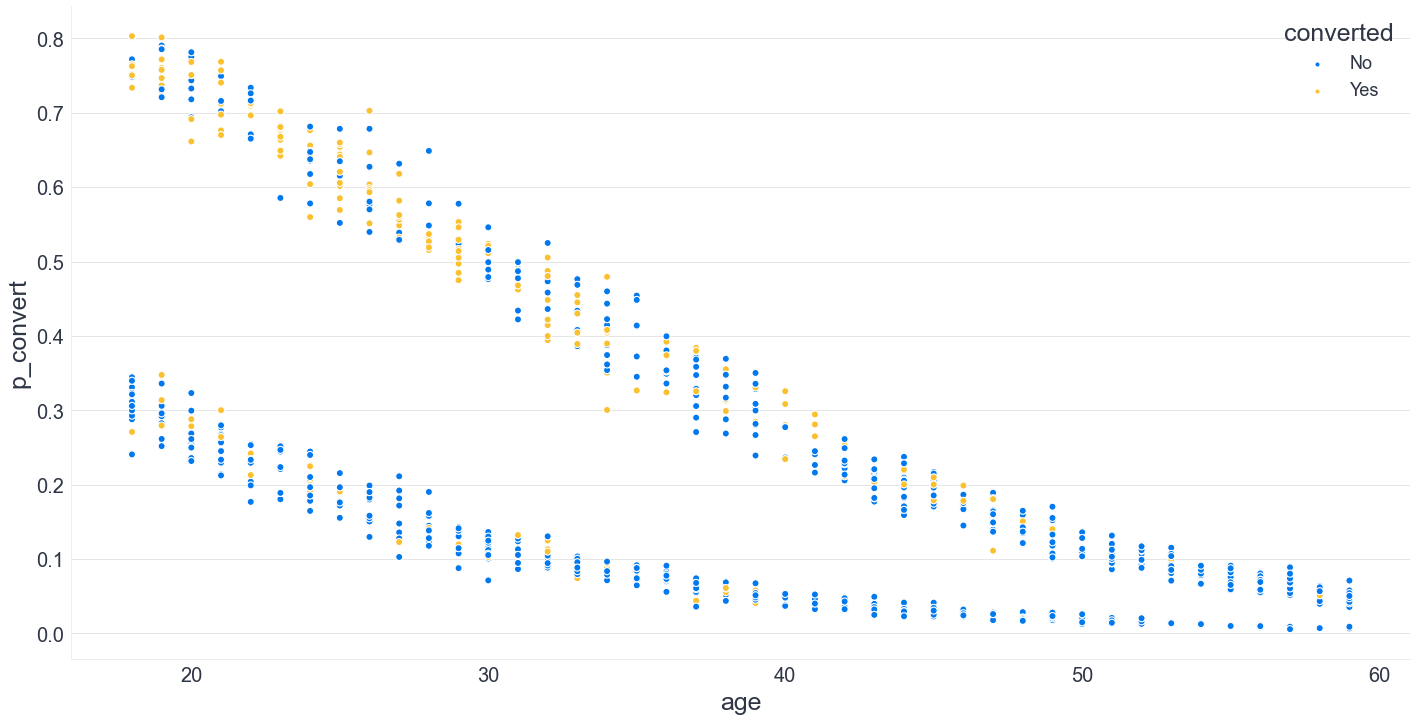

In [105]:
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.scatterplot(x="age", y="p_convert", hue="converted", data=df, ax=ax, s=200);

In [106]:
customers_table = (
    df.drop("p_convert", axis=1)
    .sample(frac=1, random_state=5)
    .reset_index()[
        [
            "age",
            "likes_videogames",
            "converted",
            "likes_videogames_bool",
            "converted_bool",
        ]
    ]
)
customers_table.head(10)

,age,likes_videogames,converted,likes_videogames_bool,converted_bool
0,40.0,No,No,0,0
1,39.0,No,No,0,0
2,25.0,Yes,Yes,1,1
3,18.0,No,No,0,0
4,29.0,Yes,No,1,0
5,45.0,Yes,No,1,0
6,44.0,No,No,0,0
7,49.0,Yes,No,1,0
8,25.0,Yes,Yes,1,1
9,48.0,Yes,Yes,1,1


# Bayesian AB Test 
The statistics test that everyone loves

## You got a new job!
<center>
  <img src="img/set-cartoon-character-hands-holding-white-gamepad-controller-isolated-white-background-3d-render_531308-632.webp" style="height:900"; />
</center>

Congratulations. You just got a new job! in this lesson you're new role is as data scientist at a video game shop. Our job is to help sell more video games. You have all sorts of data on customers and your boss wants to know who to market to.

## Your first assignment from your boss


### _"Take a look at our website checkout data._


### _I want to know which customers are most likely to convert so we can focus our marketing efforts on them_

Your boss comes to you with a question, a question that basically every data scientist will get asked in their career. Given a new feature, or some properties about the customer, which are most likely to convert?

### *Oh and I want the results by the end of the day. I have a meeting with the CEO"*

Now you're stressed out. You need to turn our results fast. Better get to it

## Customer data

In [107]:
customers_table.head(10)

,age,likes_videogames,converted,likes_videogames_bool,converted_bool
0,40.0,No,No,0,0
1,39.0,No,No,0,0
2,25.0,Yes,Yes,1,1
3,18.0,No,No,0,0
4,29.0,Yes,No,1,0
5,45.0,Yes,No,1,0
6,44.0,No,No,0,0
7,49.0,Yes,No,1,0
8,25.0,Yes,Yes,1,1
9,48.0,Yes,Yes,1,1


We look at the data and we have three things. The age, whether they like videogames, and whether they converted or not.

We can see four cases here. The first two are obvious.

We have
* People that don't like videogames that don't convert
* People that do like videogames and do convert

The second two though are more interesting

* Folks that don't like videogames but do convert
* Folks that do like videogames that don't convert

## Summarizing our DF

In [108]:
customers_table_summarized = df.groupby("likes_videogames").agg(
    converted=("converted_bool", sum), visited=("converted_bool", len)
)
customers_table_summarized["probability"] = (
    customers_table_summarized["converted"] / customers_table_summarized["visited"]
)
customers_table_summarized

,converted,visited,probability
likes_videogames,,,
No,40,486,0.082305
Yes,178,514,0.346304


Because we're short on time we start with the obvious thing, comparing people that like videogames with those who don't. Lets summarize our customer level data to a 2x2 grid for simplicity. 

Just glancing at the rows we can already see a difference. The probability of converting is more than 3 times higher for people that like videogames.

## Quick EDA Visualization

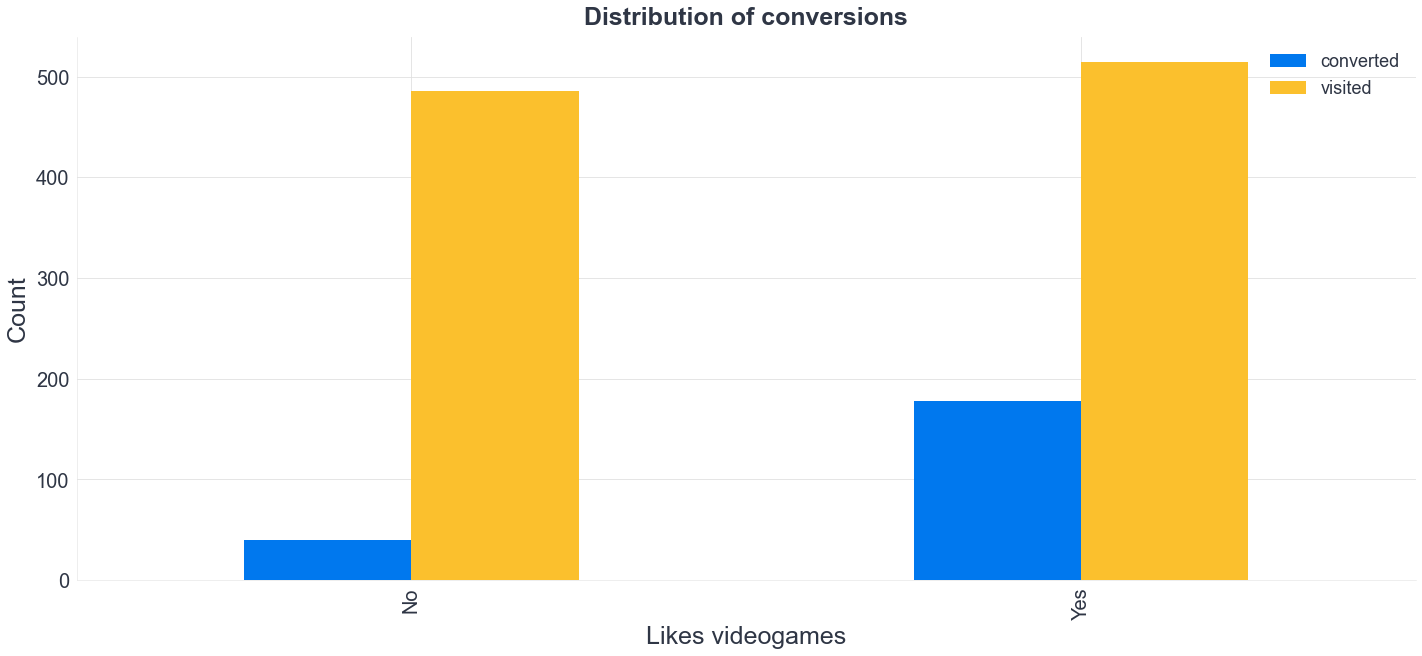

In [109]:
fig, ax = plt.subplots(figsize=(24,10))
customers_table_summarized[["converted", "visited"]].plot(kind="bar", ax=ax)
ax.set(xlabel="Likes videogames", ylabel="Count", title="Distribution of conversions");

It's always a good idea to plot the results as well, just as a double check. We can see the orange bars are very similar so that allows us to compare the blue bars directly. Again it's pretty clear people who like videogames are much more likely to convert.

## A/B Test in PyMC

$$
\begin{aligned}
p_i & \sim \text{Beta}(a, b) \\
y_i & \sim \text{Binomial}(n_i, p_i) \\
\text{for } i &= 1, \cdots, 2
\end{aligned}
$$



In [110]:
visited = customers_table_summarized["visited"].to_numpy()
converted = customers_table_summarized["converted"].to_numpy()
coords = {"likes_videogames": customers_table_summarized.index}

with pm.Model(coords=coords) as ab_test_model:
    p_convert = pm.Beta("p_convert", 2, 2, dims="likes_videogames")
    pm.Binomial("y", p=p_convert, n=visited, observed=converted)
    idata_likes_video_games = pm.sample(chains=4, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_convert]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


We're not quite sure how to AB test in Bambi so for now we just use PyMC. Luckily the model is quite small so its quick to code up. Lets get to sampling and see what we get


## Let's verify our sampling

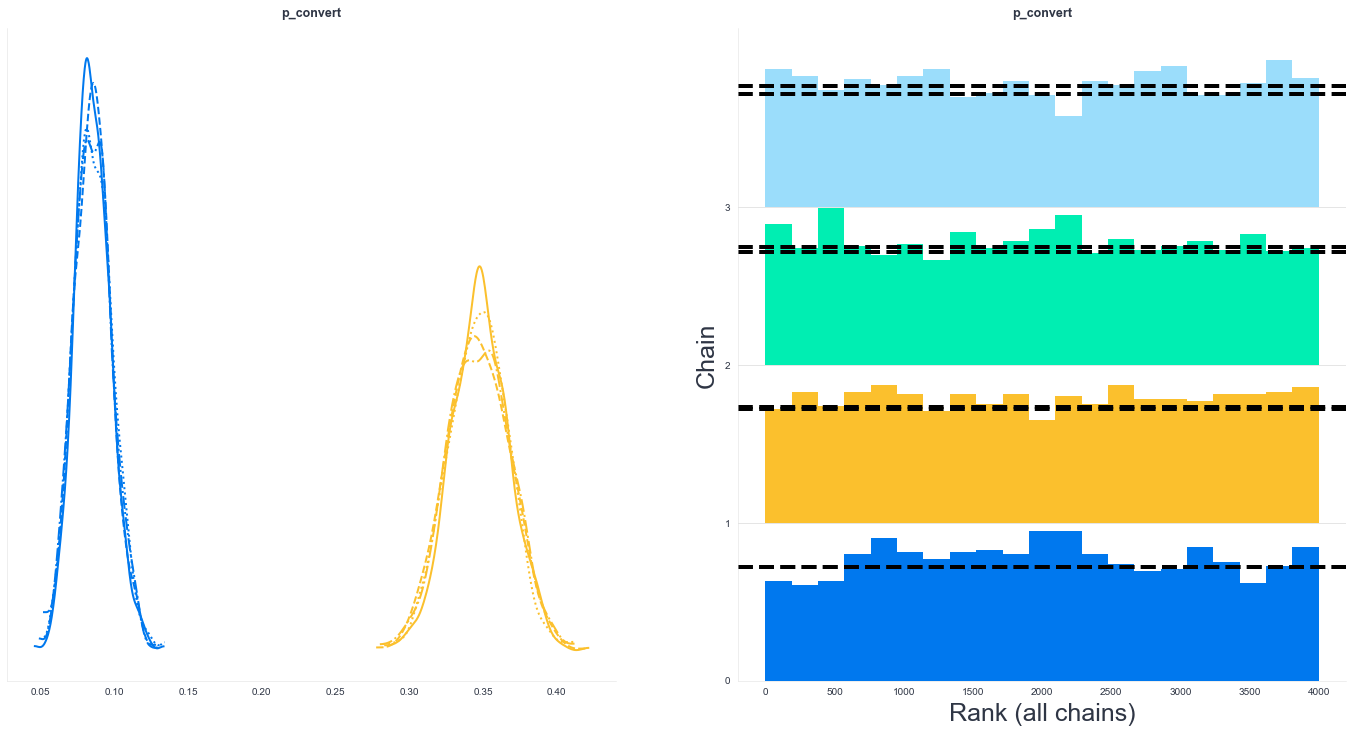

In [111]:
az.plot_trace(idata_likes_video_games, kind="rank_bars", figsize=FIGSIZE);

Our sampling looks good, and we can already see from the KDE that the conversion probabilities are quite different between the two groups.

## Comparing the two groups

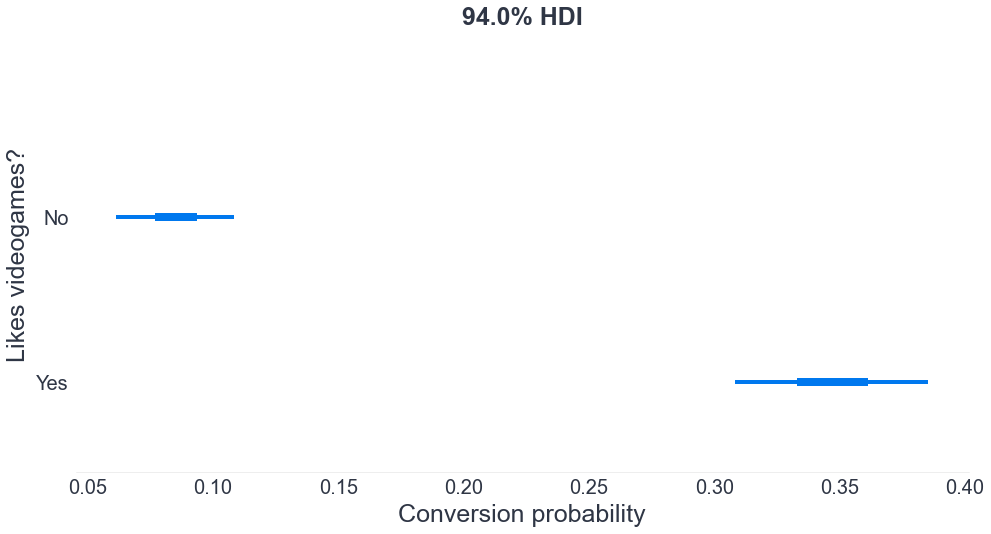

In [112]:
fig, ax = plt.subplots(figsize=(16, 8))
az.plot_forest(idata_likes_video_games, var_names=["p_convert"], ax=ax, combined=True);
ax.set(
    xlabel="Conversion probability",
    ylabel="Likes videogames?",
    yticklabels=reversed(customers_table_summarized.index)
);

Forestplots are another great tool to compare posteriors. It's very clear there's a difference. People who like videogames have much higher probability of converting than those who don't. In this case it looks like the  mean conversion probability of folks that video games is around 30 to 40%, where as the ones who don't are around 8% to just under 15%

## Section Recap
* Our boss asked us to analyze the probability of customer converting
* Wrote a Bayesian AB Test to show a credible difference in conversion
  * Only included video game preference
  * Did not include age
* The provided data includes
  * Whether people like video games
  * Age
  * Whether they converted or not

# Incorporating age
How continuity makes things hard

## Showing your boss the results

### *Well that was obvious, of course people that like videogames purchase more*

### *Why didn't you include age? How does that affect things?*

### *And Hurry up! I have a meeting with the CEO soon*

## Unfortunately we've only worked with discrete data

In [113]:
customers_table["likes_videogames"]

0       No
1       No
2      Yes
3       No
4      Yes
      ... 
995     No
996     No
997     No
998    Yes
999    Yes
Name: likes_videogames, Length: 1000, dtype: object

So far we've only worked with binary data, meaning it can only take on one of two values, and that's why we had AB testing.

## How do work with a continuous attribute?

In [114]:
customers_table["age"]

0      40.0
1      39.0
2      25.0
3      18.0
4      29.0
       ... 
995    34.0
996    22.0
997    47.0
998    26.0
999    53.0
Name: age, Length: 1000, dtype: float64

We need to figure out how to work with a continuous attribute like age. It's so many groups! Infinity groups! 

## A, B, C, D, E Comparison


In [115]:
customers_table["age_group"] = customers_table["age"].apply(lambda x: f"({(x - x%10):.0f} - {(x - x%10+10):.0f}]")
customers_table

,age,likes_videogames,converted,likes_videogames_bool,converted_bool,age_group
0,40.0,No,No,0,0,(40 - 50]
1,39.0,No,No,0,0,(30 - 40]
2,25.0,Yes,Yes,1,1,(20 - 30]
3,18.0,No,No,0,0,(10 - 20]
4,29.0,Yes,No,1,0,(20 - 30]
...,...,...,...,...,...,...
995,34.0,No,No,0,0,(30 - 40]
996,22.0,No,No,0,0,(20 - 30]
997,47.0,No,No,0,0,(40 - 50]
998,26.0,Yes,No,1,0,(20 - 30]


One thing we could do is split the continuous variable into groups, which makes it discrete. This allows us to use ABCDE testing framework.

## Summarizing our derived groups

In [116]:
customers_table_summarized = customers_table.groupby("age_group").agg(
    converted=("converted_bool", sum), visited=("converted_bool", len)
)
customers_table_summarized["probability"] = (
    customers_table_summarized["converted"] / customers_table_summarized["visited"]
)
customers_table_summarized

,converted,visited,probability
age_group,,,
(10 - 20],19,50,0.380000
(20 - 30],98,247,0.396761
(30 - 40],64,234,0.273504
(40 - 50],28,234,0.119658
(50 - 60],9,235,0.038298


To make things easier to see lets summarize this into a smaller dataframe as well. Even without statistical analysis we're seeing some trends. As people get older, it becomes less likely they convert. Let's dig in further.

## Another quick EDA

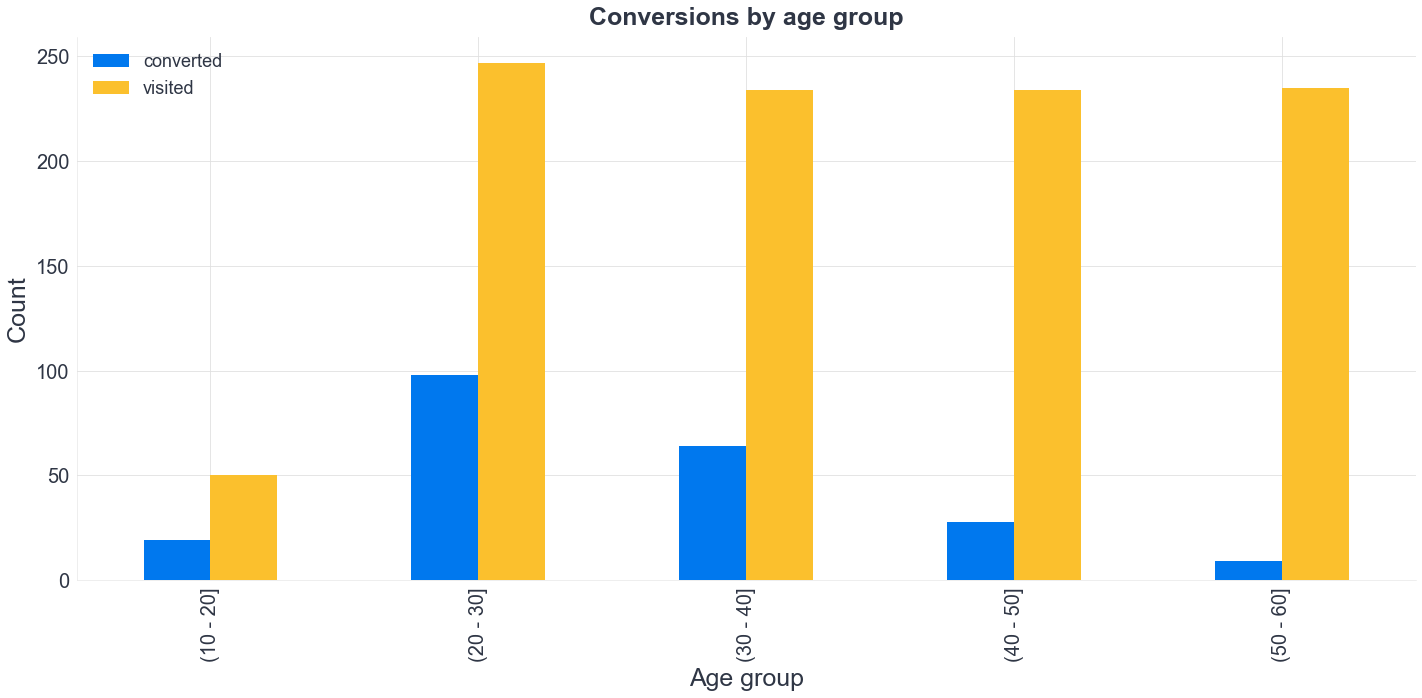

In [117]:
fig, ax = plt.subplots(figsize=(24,10))
customers_table_summarized[["converted", "visited"]].plot(kind="bar", ax=ax)
ax.set(xlabel="Age group", ylabel="Count", title="Conversions by age group");

The chart confirms what we saw in the table. Older people are less likely to convert.

## Our bucketed model

$$
\begin{aligned}
p_i & \sim \text{Beta}(a, b) \\
y_i & \sim \text{Binomial}(n_i, p_i) \\
\text{for } i & = 1, \cdots, 5
\end{aligned}
$$



In [41]:
coords = {"age_group": customers_table_summarized.index}
visited = customers_table_summarized["visited"].to_numpy()
converted = customers_table_summarized["converted"].to_numpy()

with pm.Model(coords=coords) as abcde_test_model:
    p_convert = pm.Beta("p_convert", 2, 2, dims="age_group")
    pm.Binomial("y", p=p_convert, n=visited, observed=converted)
    idata_groups = pm.sample(chains=4, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_convert]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Lets sample again. It's still the same Beta-Binomial model. The only difference is that we have 5 groups now. Notice how we changed the coords.

## Checking sampling

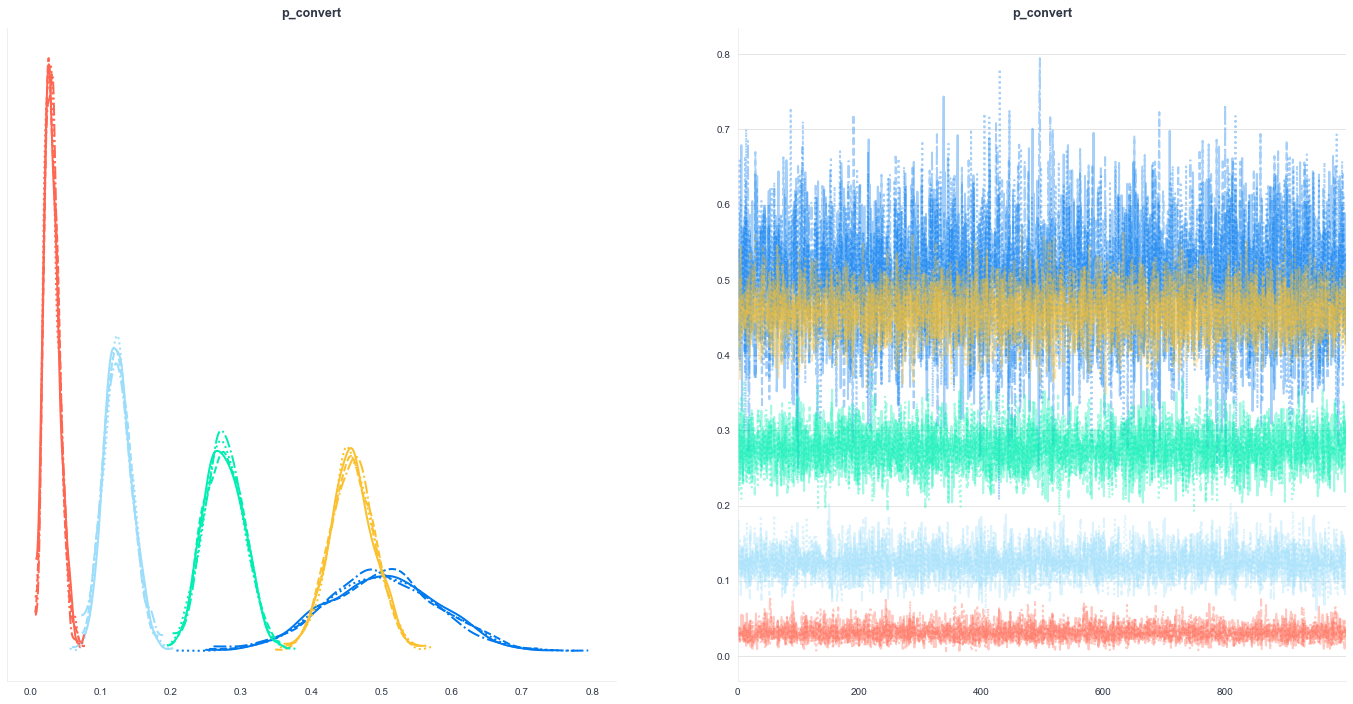

In [42]:
az.plot_trace(idata_groups, figsize=(24, 12));

Now we can see something going on, but this doesn't exactly answer our question of how age relates to conversion directly. We can compare group to group but our boss specifically wants to know exactly how the percentage conversion drops by age.

## Comparing our age groups

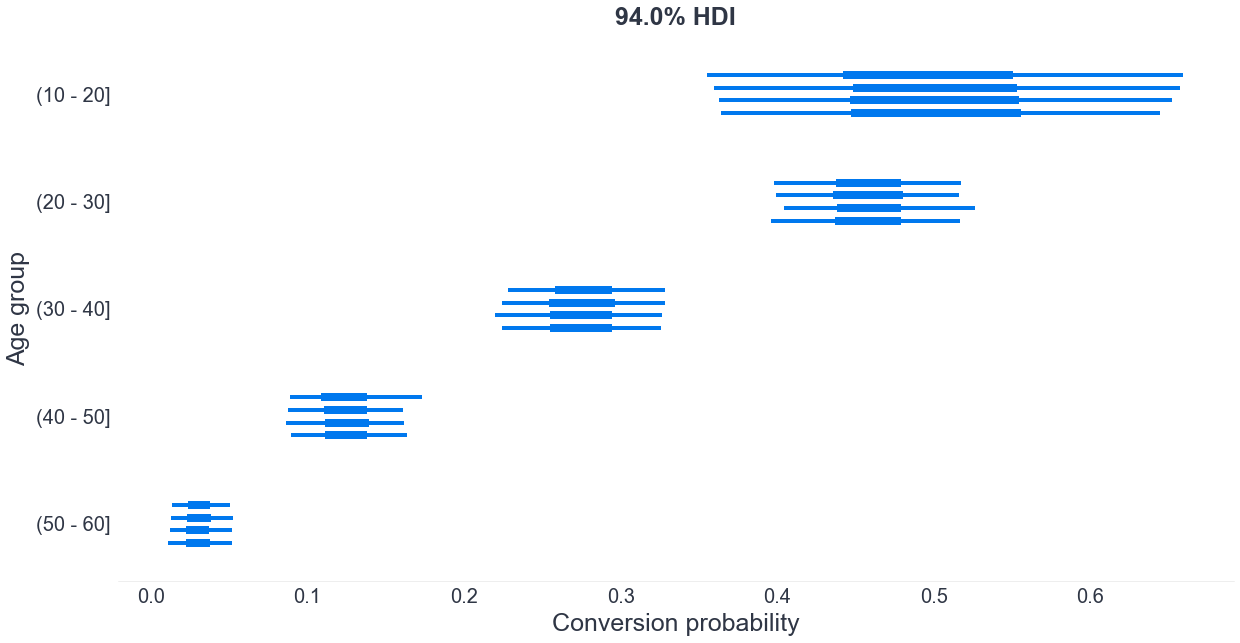

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
az.plot_forest(idata_groups, var_names=["p_convert"], ax=ax);
ax.set(
    xlabel="Conversion probability",
    ylabel="Age group",
    yticklabels=reversed(customers_table_summarized.index)
);

## But wait, we know regression!

In [45]:
converted_bool = df["converted_bool"].to_numpy()
coords = {"likes_videogames": customers_table_summarized.index}


with pm.Model(coords=coords) as ab_test_lin_reg:
    β = pm.Normal("β", 0, 1, dims="likes_videogames")
    mu = pm.Deterministic("p", β[0] + β[1] * df["age"].to_numpy())
    
    # Switch to Bernoulli because we're predicting individual observations
    obs = pm.Bernoulli("obs", p=mu, observed=converted_bool)

Since we know how to do linear regression with continuous predictors, why not using it here as well? 

It's pretty much the same stuff, we just only needed to change from `pm.Normal()` to `pm.Bernoulli()`. So easy!

## Lets try sampling

In [46]:
with ab_test_lin_reg:
    idata_age_reg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'β': array([ 0.51153866,  0.70917544, -0.32728488,  0.2441239 ,  0.16684658])}

Initial evaluation results:
{'β': -5.07, 'obs': -inf}

Ugh we're running into sampler issues. Looking at the error we see some things about negative p_convert but we don't ahve time for this

## Forget Bayes. Go back to OLS

In [47]:
import statsmodels.formula.api as smf

results = smf.ols("converted_bool ~ age", data=df).fit()
results.params

Intercept    0.777323
age         -0.014161
dtype: float64

We obviously see a trend related to age though and we want to use regression. Our Bayesian regression isn't working so lets just go to statsmodel and use ordinary least squares. 

And look! We immediately get an answer. The probability of conversion drops 1% for every year. Check it out, now we know the probability of conversion across our observed values.

Lets go tell our boss!

## Regression problems

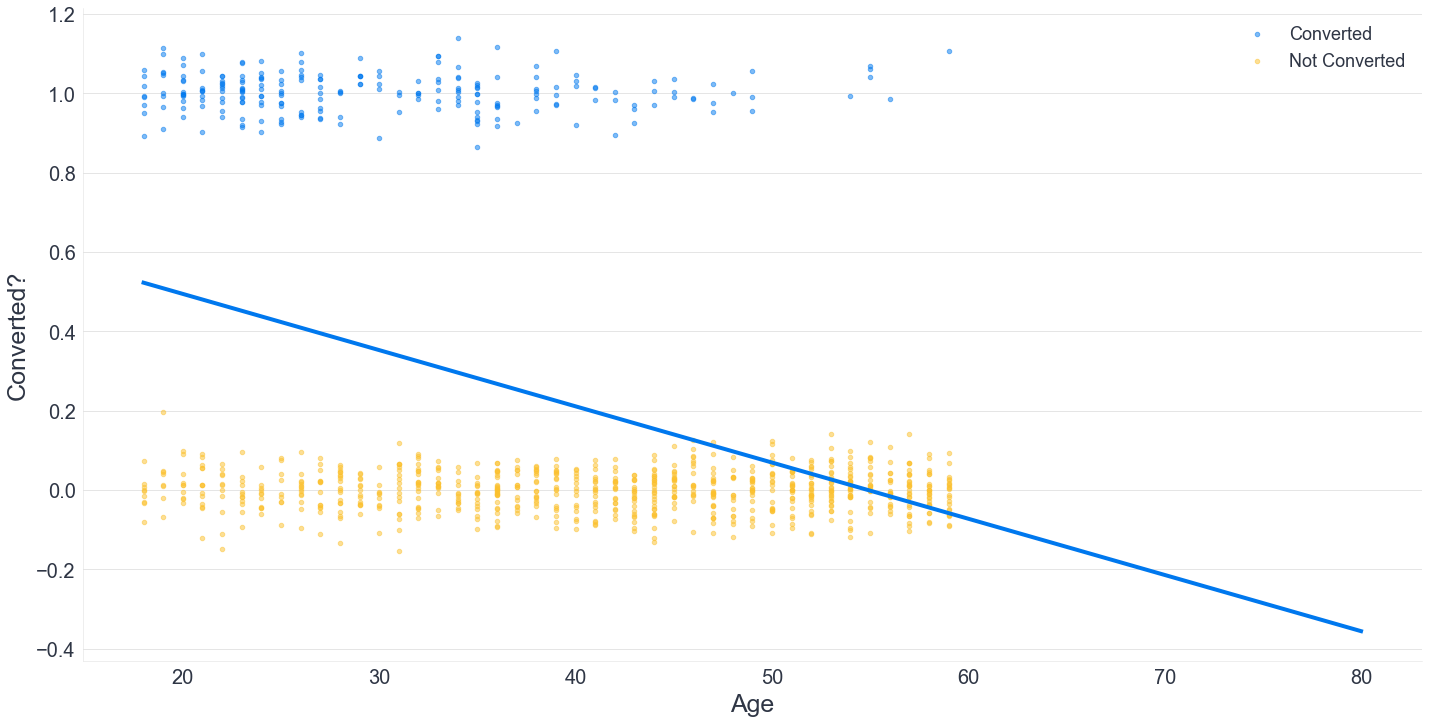

In [48]:
fig, ax = plt.subplots(figsize=(24, 12))
converted_filter = df["converted_bool"].astype(bool)

# Add some jitter
jittered_y = df["converted_bool"]  + stats.norm(scale=0.05).rvs(df.shape[0])

alpha = 0.5
ax.scatter(
    df.loc[converted_filter, "age"],
    jittered_y[converted_filter],
    label="Converted",
    alpha=alpha,
    s=80,
)

ax.scatter(
    df.loc[~converted_filter, "age"],
    jittered_y[~converted_filter],
    label="Not Converted",
    alpha=alpha,
    s=80,
)

age_x = np.linspace(df["age"].min(), 80, 1000)
y_pred = results.params[0] + results.params[1] * age_x
ax.plot(age_x, y_pred)
ax.legend()
ax.set(xlabel="Age", ylabel="Converted?");

But before we do lets just double check out plot. 
Negative probability? This is why our sampler was failing, it was telling us something.
Oh man, if we had reported these results we would have been fired
But look at the age of 60, something seems off?


**Note:** I'm not sure I like this plot because it mixes things in two different scales. The binary scale of the response and the continuous scale in (0, 1) of the probability. When I saw plots like this in the past it wouldn't have the jitter, so you would only pay attention to the probability scale.

## Section Recap
* Traditional AB Testing framework relies on discrete variables
* We tried converted a continuous variable into a discrete one 
  * Doesn't directly answer our question though
* Regression didn't work
  * Ordinary least squares produced a non sensical answer
  * Bayesian linear regression totally failed
 * An advantage of modern Bayesian frameworks is they "tell you" when something is wrong

# Link Functions
The most important concept of this course

## Statistics and math review

* Probability is 0 1 bounded
* Linear regression is not

That's a problem if we're trying to estimate probability with plain linear regression

Linear regression makes predictions that range from negative infinity to positive infinity. So that does not work for probability.

What if we can remap our observed to be between 0 and 1?

Turns out we you already know how. Remember our log transformation in the last lesson? What if we can apply a transformation?

## Sigmoid transformation
$$ \large
S(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}
$$


This is our sigmoid function. You may have seen it before, its quite common in many places such as Neural Nets, machine learning and other spaces. Its easier to understand when plotted so lets get to that

## Plotting the Sigmoid function

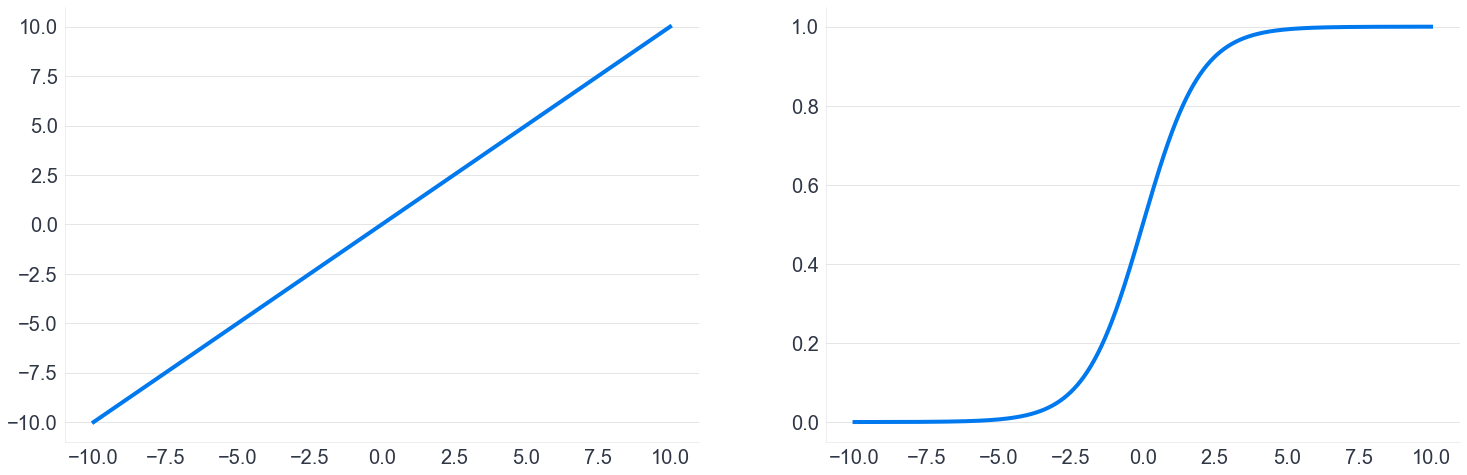

In [49]:
x = np.linspace(-10, 10, 1000)
y = x
transformed_y = 1 / (1 + np.exp(-x))

fig, axes = plt.subplots(1, 2, figsize=(25, 8))
axes[0].plot(x, y)
axes[1].plot(x, transformed_y);

And here's what it looks like in code

**Note** We will switch this to an animation to make it more clear what's happening

## Logistic Regression in PyMC

$$
\begin{aligned}
\beta_{\text{intercept}} & \sim \text{Normal} \\
\beta_{\text{age}} & \sim \text{Normal} \\
\eta_i & = \beta_{\text{intercept}} + \beta_{\text{age}} \text{Age}_i \\
p_i & = \text{sigmoid}(\eta_i) \\
y_i & \sim \text{Bernoulli}(p_i)
\end{aligned}
$$

In [50]:
converted_bool = df["converted_bool"].to_numpy()

with pm.Model() as logistic_regression_model:
    # This is all the same linear regression as before
    β = pm.Normal("β", 0, 1, size=2)
    
    # In logistic regression "mu" and "p_conversion" are the same
    # Known as the 'linear predictor'
    eta = pm.Deterministic("eta", β[0] + β[1] * df["age"])

    # Our is our new sigmoid transformation
    p_conversion = pm.Deterministic("p_conversion", pm.math.sigmoid(eta))

    # Switch to Bernoulli because we're predicting individual observations
    pm.Bernoulli("y", p=p_conversion, observed=converted_bool)
    idata_sigmoid = pm.sample(chains=4, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Let's take our sigmoid transformation and add it into our model. We'll wrap it in `pm.Deterministic()` so we can review the output later.

In logistic regression "mu" and "p" are the same (the expected value of the bernoulli distribution). So β[0] + β[1]*df["age"] is actually "eta" and

"sigmoid(eta)" is then "p" or "mu"

## Inspecting our modeling results

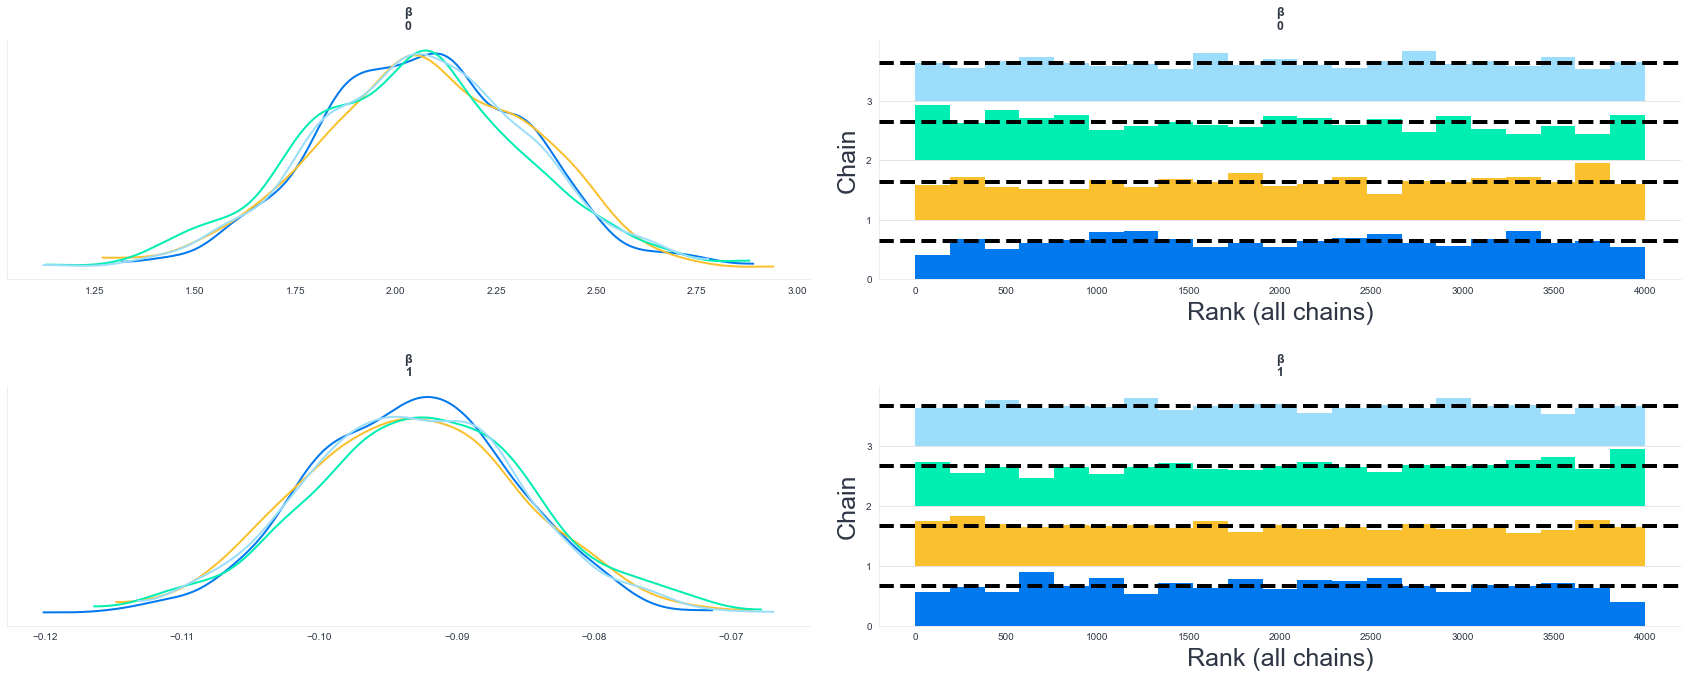

In [51]:
az.plot_trace(
    idata_sigmoid,
    var_names=["β"],
    compact=False,
    kind="rank_bars",
    figsize=(24, 10),
    backend_kwargs={"tight_layout": True},
);

As always we'll be good Bayesians and review the model results before moving on.

## Estimates of the results

In [52]:
az.summary(idata_sigmoid, var_names=["β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],2.059,0.270,1.529,2.536,0.01,0.007,770.0,920.0,1.0
β[1],-0.093,0.008,-0.109,-0.079,0.00,0.000,763.0,921.0,1.0


## This is the generalized linear model


Along this course we've always had

$$
\eta_i = \mathbf{x}_i^T\mathbf{\beta} = \beta_0 + \beta_1 X_{1, i} + \cdots + \beta_p X_{p, i}
$$



The magic of the link function is that

$$
g(\mu_i) = \eta_i
$$



And since the link function is invertible

$$
\mu_i = g^{-1}(\eta_i)
$$

This is what allows us to compute $\eta_i$ as in plain linear regression and map it into a probability scale with $g^{-1}$, which is the sigmoid function in our case.

You're going to see other versions of this in the upcoming lesson

## Bambi functions make generalized linear models easy

<center>
  <img src="img/Bambi_logo.png" style="height:900"; />
</center>

The good news is that with Bambi makes generalized linear models easy and fast. We can quickly go from linear model idea to results, to plots in minutes. Our old boss at the videogame store would be proud.

## Generalized Linear models and Link functions in Bambi

In [53]:
model = bmb.Model("converted[Yes] ~ age", df, family="bernoulli", link="logit")
idata = model.fit(draws=2000, chains=4, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.205,0.279,1.687,2.734,0.004,0.003,4725.0,5015.0,1.0
age,-0.097,0.008,-0.113,-0.082,0.000,0.000,4054.0,4616.0,1.0


Turns out we can and surprise we get the same answer as the PyMC Model but with way less code. This is awesome


## Too much randomness in names

* $g$
    * Logit
* $g^{-1}$
    * Expit
    * Sigmoid
    * Logistic

Now names in statistics are bad, and unfortunately all too random. So far we used the name "logistic". And that's good, but that's the inverse of the link function, $g^{-1}$. But Bambi asks for the name of $g$ directly, which is the Logit function.


Unfortunately Stats is definitely THE discipline of name issues

We got our result though so lets move on to our end to end analysis!

## Section Recap
* Transformations are the tool that turns linear regression into generalized linear equations
* Typically these are referred to as link functions 
* In our AB testing case the logit link function compressed our outputs into the 0 1 range
  * Also called the Sigmoid transformation
  * Has many other names as well

# End to End Analysis with Bambi 
From start to finish in our favorite model builder

## Single boolean covariate regression

In [54]:
model = bmb.Model("converted[Yes] ~ likes_videogames + 0", df, link="logit", family="bernoulli")
idata = model.fit(draws=2000, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likes_videogames]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
likes_videogames[No],-2.185,0.149,-2.462,-1.906,0.002,0.001,8055.0,5193.0,1.0
likes_videogames[Yes],-0.672,0.093,-0.848,-0.499,0.001,0.001,8267.0,5715.0,1.0


Here's how we calculate the difference in behavior between folk that like videogames and those that don't. We use `+0` to include an intercept. In this case we'll skip the diagnostics for brevity.

## A ridge plot

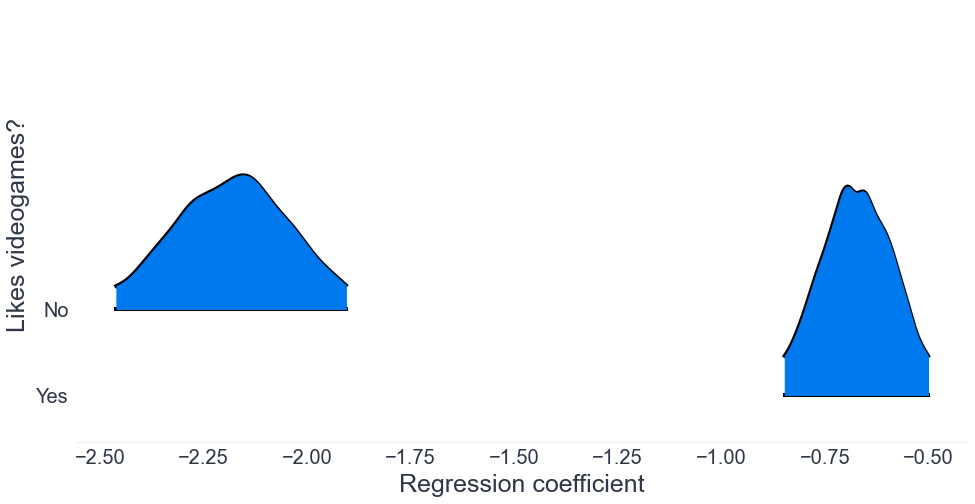

In [55]:
fig, ax = plt.subplots()
az.plot_forest(idata, var_names=["likes_videogames"], kind="ridgeplot", combined=True, ax=ax);
ax.set(
    ylabel="Likes videogames?",
    xlabel="Regression coefficient",
    yticklabels=["Yes", "No"],
);

This time we make a ridgeplot which indeed shows there a pretty big difference in the regression coefficient. These values are not on the probability scale yet, our next step will be to convert them.

## Convert to probability

In [56]:
special.expit(az.summary(idata)["mean"])

likes_videogames[No]     0.101106
likes_videogames[Yes]    0.338049
Name: mean, dtype: float64

Now check this out. If we want to convert to probability we run the output of our regression through the logistic/expit function.

Do these numbers look familiar? that's because its the exact same thing as our first AB Test. When we transform the means we end up with our original probabilities. How cool is that?

## Fitting on age and A infinite testing

In [57]:
model = bmb.Model("converted[Yes] ~ age", df, link="logit", family="bernoulli")
idata = model.fit(draws=2000, chains=4, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.205,0.279,1.687,2.734,0.004,0.003,4725.0,5015.0,1.0
age,-0.097,0.008,-0.113,-0.082,0.000,0.000,4054.0,4616.0,1.0


Instead of fitting on age groups we can now directly use age as a covariate. Technically this is A infinite testing as we can compare any value of age with any other value of age, leading to an infinite amount of comparisons

## The logistic regression result

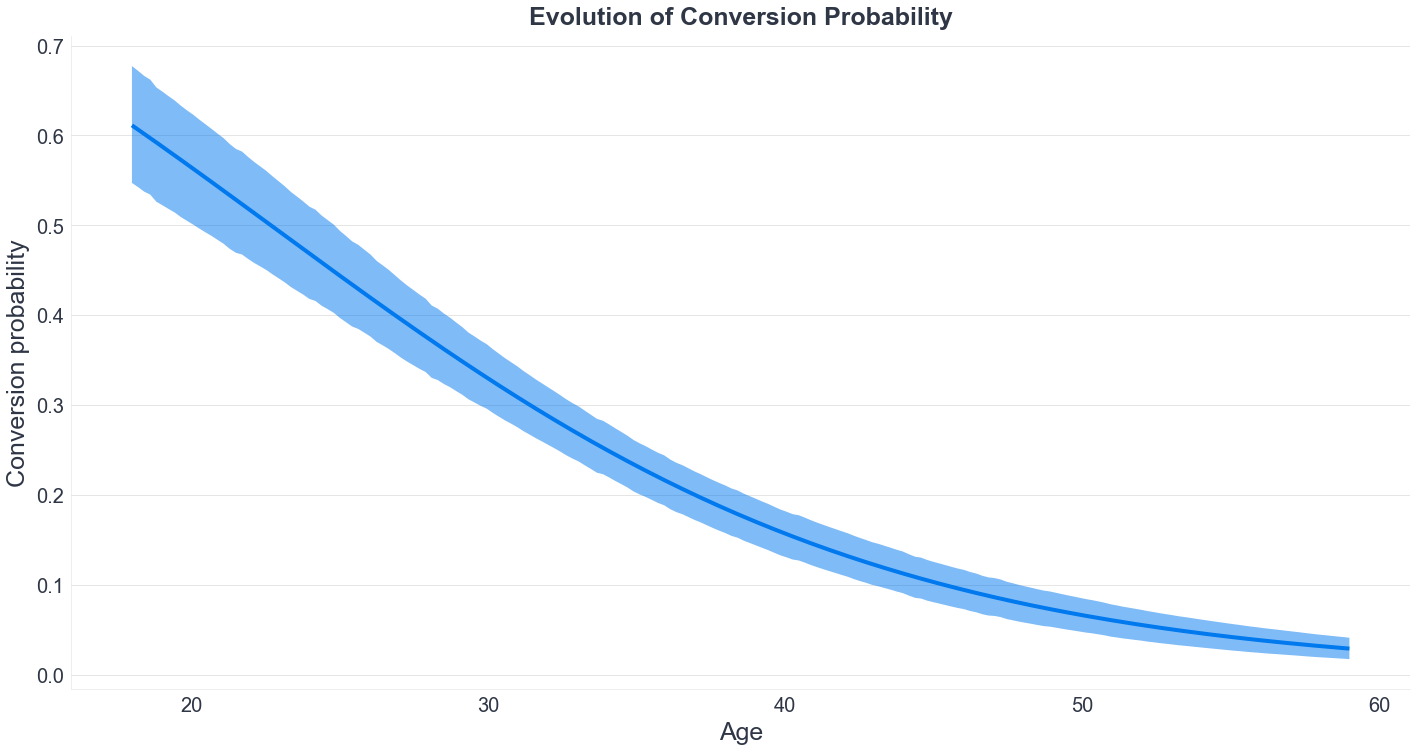

In [58]:
fig, ax = plt.subplots(figsize=(24, 12))
bmb_plots.plot_cap(model, idata, ["age"], ax=ax)
ax.set(xlabel="Age", ylabel="Conversion probability", title="Evolution of Conversion Probability");

Check this out! We have the answer for our boss. As age increases the conversion probability decreases. The plot is worth a thousand words!

This is basically A infinite testing because we have the probabilities for an INFINITE amount of ages along the horizontal axis. How cool is that?!

## Lets fit on age and likes videogames


In [59]:
model_age_videogames = bmb.Model(
    "converted[Yes] ~ age + likes_videogames", df, link="logit", family="bernoulli"
)
idata_age_videogames = model_age_videogames.fit(
    draws=2000, chains=4, target_accept=0.85, random_seed=SEED
)
az.summary(idata_age_videogames)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, likes_videogames]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.488,0.314,0.870,2.050,0.004,0.003,6616.0,6245.0,1.0
age,-0.109,0.009,-0.126,-0.091,0.000,0.000,4026.0,4741.0,1.0
likes_videogames[Yes],1.793,0.201,1.420,2.177,0.003,0.002,4517.0,5123.0,1.0


## Age and Videogame plot

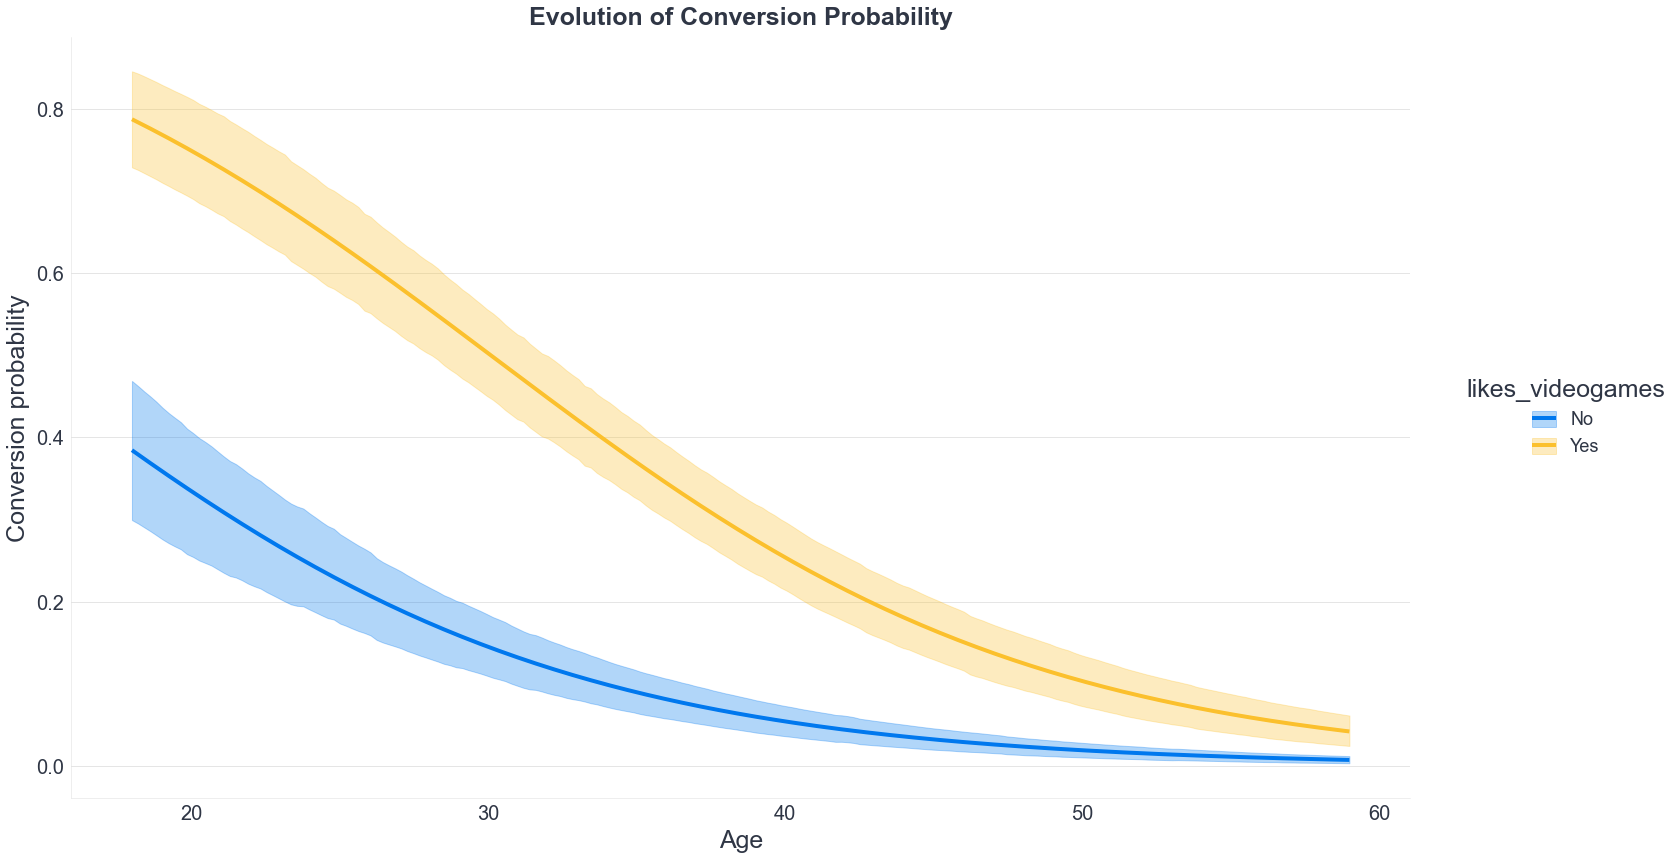

In [60]:
fig, ax = plt.subplots(figsize=(24, 14))
bmb_plots.plot_cap(model_age_videogames, idata_age_videogames, ["age", "likes_videogames"], ax=ax)
ax.set(xlabel="Age", ylabel="Conversion probability", title="Evolution of Conversion Probability");

Holy crap guys this result is truly mindblowing. Not only do we know the probability at every age. When we control for whether people like videogames or not we see a totally different trend.

Now when you go talk to your boss you not only provided the age insight, but you can recommend who to target per age and preference. And with this intuitive plot your boss is sure to give you a rise!

## Making a prediction

In [61]:
df_predict = pd.DataFrame({"age": [20, 30, 40], "likes_videogames": ["No", "Yes", "Yes"]})
predictions = model.predict(idata, data=df_predict, inplace=False, kind="pps")
predictions.posterior_predictive.mean(["chain", "draw"])["converted"]

<xarray.DataArray 'converted' (converted_dim_0: 3)>
array([0.571625, 0.334375, 0.15925 ])
Coordinates:
  * converted_dim_0  (converted_dim_0) int64 0 1 2

Let's say we have three new people aged 20, 30, and 40. The first person does not like videogames, but the other two do. 

Check this out! 

Turns out a 20 year old will convert at 50 percent rate, even if they don't like videogames, which is more than 30 or 40 year old that does like video games!

Now if any new customer comes in we can predict their probabilty conversion. So powerful!

## Section Recap
* Bambi makes logistic regression quite easy to build regression with multiple covariates
  * In this case age and videogame preference
* `plot_cap` helps us easily visualize continuous results
  * Gives us the answer for probability of conversion with age
  * Since this is regression we can even control for preference quite easily
  * Can easily discern the differing trend in conversion between the two groups
* Predictions are quite easy to generate as well

# Modeling U.S.A Election Preferences
Who will folks vote for in the 2016 US Election

## Voter preference for candidates

<center>
  <img src="img/presidential-election-background_1057-1753.jpg" style="height:850px"; />
</center>

We're going to be modeling voters self reported preferences for voting for either Hilary Clinton or Donald Trump. Now  we're going to put politics aside and focus on the statistics.

## Election Dataset

In [62]:
data = bmb.load_data("ANES")
data

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican
...,...,...,...
416,trump,46,independent
417,clinton,64,democrat
418,someone_else,31,independent
419,clinton,39,democrat


The ANES is a nationally representative, cross-sectional survey used extensively in political science. This is a dataset from the 2016 pilot study, consisting of responses from 1200 voting-age U.S. citizens.

https://electionstudies.org/data-center/anes-2016-pilot-study/

## Summary Statistics

In [63]:
data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


## Party Preference and Age

In [64]:
model_age = bmb.Model("vote[clinton] ~ party_id + scale(age)", data, family="bernoulli")
model_age.build()
model_age

Formula: vote[clinton] ~ party_id + scale(age)
Family name: Bernoulli
Link: logit
Observations: 373
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 3.2871)
    party_id ~ Normal(mu: [0. 0.], sigma: [5.4007 6.0634])
    scale(age) ~ Normal(mu: 0.0, sigma: 2.5)

And one trick we didn't show, you don't even need to specify the link function as Bambi comes with nice defaults. When we ask for the Bernoulli family, it automatically selects the logit link.

**Note for Ravin:** At this point we will have already introduced formula transformations (i.e. log) but I'm not sure if we'll have `scale()` covered. What do you think is the best thing between covering `scale()` when we first show these transformations are possible in Lesson 3, or here when it's actually used?

## Model Graph View

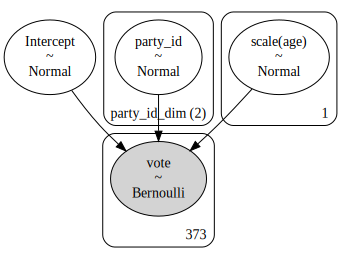

In [85]:
model_age.graph()

## Sampling

In [66]:
inf_data_age = model_age.fit(chains=4, draws=2000, tune=2000, random_seed=1234)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, party_id, scale(age)]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 27 seconds.


In [67]:
az.summary(inf_data_age, var_names=["party_id", "scale(age)"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
party_id[independent],-2.520,0.325,-3.129,-1.911
party_id[republican],-5.081,0.553,-6.127,-4.046
scale(age),-0.356,0.151,-0.634,-0.065


## Create a new dataset with age going from 18 to 90 for predictions

In [68]:
age = np.arange(18, 91)
parties = ["democrat", "republican", "independent"]
new_data = pd.DataFrame({"age": np.tile(age, 3), "party_id": np.repeat(parties, len(age))})
new_data

,age,party_id
0,18,democrat
1,19,democrat
2,20,democrat
3,21,democrat
4,22,democrat
...,...,...
214,86,independent
215,87,independent
216,88,independent
217,89,independent


Now we want to make predictions for every each age and voter preference. To do so lets create a new dataframe that we'll use in our prediction machine to generate these predictions 

## Define Prediction Machine

In [69]:
# Predict mean of P(vote = clinton | age) by plugging in new data
model_age.predict(inf_data_age, data=new_data)
vote_mean = az.extract_dataset(inf_data_age.posterior, num_samples=500)["vote_mean"]

## Plot our predictions

In [70]:
from matplotlib.lines import Line2D


def plot_vote_predictions(posterior_mean, ax):

    for i, party in enumerate(parties):
        idx = new_data.index[new_data["party_id"] == party]
        ax.plot(age, posterior_mean[idx], alpha=0.05, color=f"C{i}")

    ax.axhline(y=0, ls="--", color="#a3a3a3", zorder=1)
    ax.axhline(y=1, ls="--", color="#a3a3a3", zorder=1)
    ax.set_ylabel("P(vote=clinton | age)")
    ax.set_xlabel("Age", fontsize=25)
    ax.set_ylim(-0.025, 1.025)
    ax.set_xlim(18, 90)

    fig.subplots_adjust(top=0.925, left=0.1, right=0.95, bottom=0.1)

    labels = [party.capitalize() for party in parties]

    # Create legend
    handles = [
        Line2D(
            [0],
            [0],
            label=label,
            marker="o",
            color="None",
            markerfacecolor=f"C{i}",
            markeredgewidth=0,
            markersize=10,
        )
        for i, label in enumerate(labels)
    ]

    # Add legend
    x_center = 0.1 + (0.95 - 0.1) / 2
    legend = fig.legend(
        handles=handles,
        ncol=5,
        loc="lower center",
        bbox_to_anchor=(x_center, 0.925),
        handletextpad=0.2,
        columnspacing=2,
        fontsize=25,
    )

REaders Note: We could use plot cap as well but opted to do something different here so you could have a reference to plotting code as well for your own work.

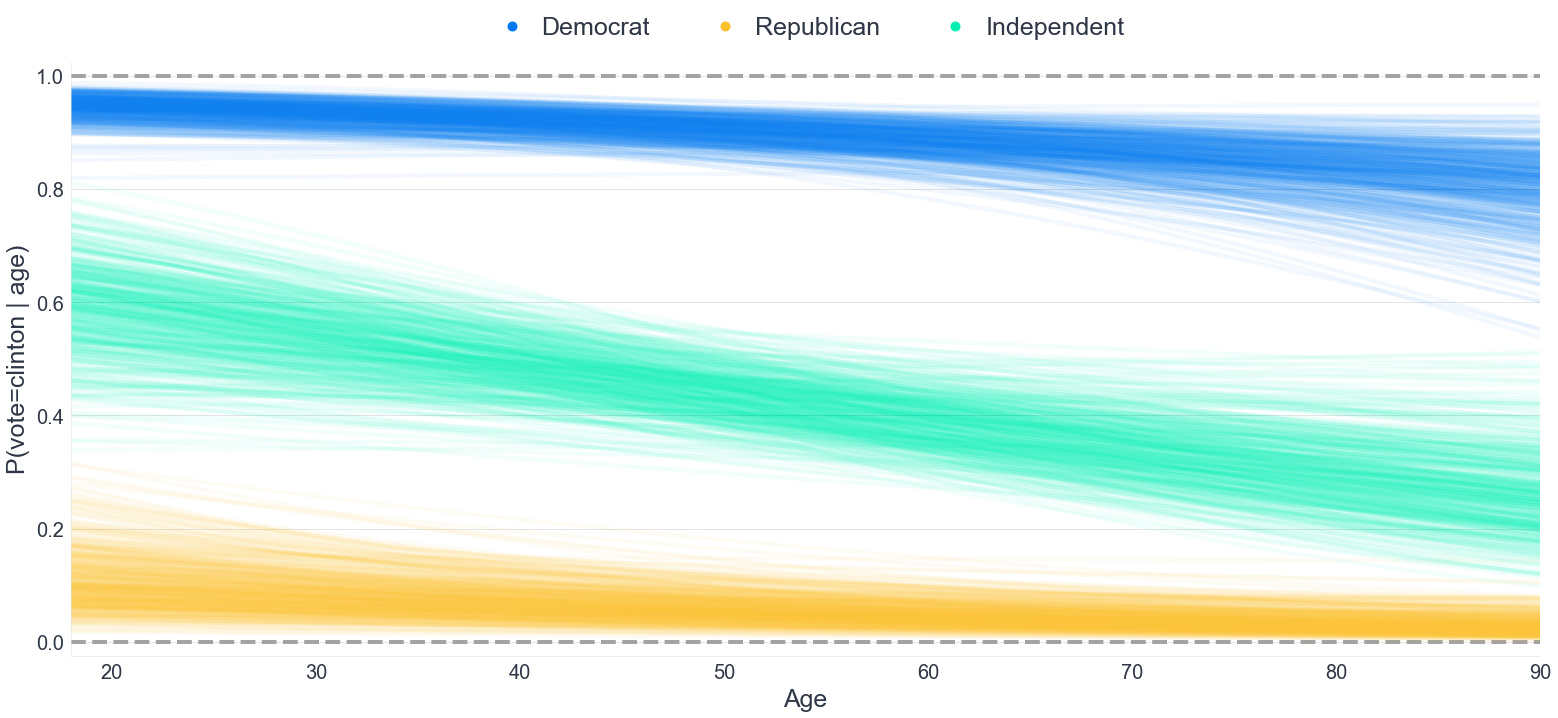

In [71]:
fig, ax = plt.subplots(figsize=(24, 10))
plot_vote_predictions(vote_mean, ax=ax)

Now this is interesting. We can see that obvious patterns. People that are Republican tend to vote for Trump, folks that are democrat vote for Clinton, and modeates are about 50/50. But age seems to be a factor. Across all age groups the number of votes declines

## Voting Age Interaction Model

In [72]:
model_age_interaction = bmb.Model(
    "vote[clinton] ~ party_id + party_id:scale(age)", data, family="bernoulli"
)

In [73]:
# This is skipped as its not working right now
# model_age_interaction.set_alias({"party_id": "intercept", "party_id:scale(age)": "age"})

Now we're going to rerun our analysis and do something subtle here. We'll change the party_id categorical indicator to have an interaction with age.

Interaction with age means that each party will have a different slope for age (or will be allowed to have, because they can end up being the same once estimated)

## Model graph with the interaction term

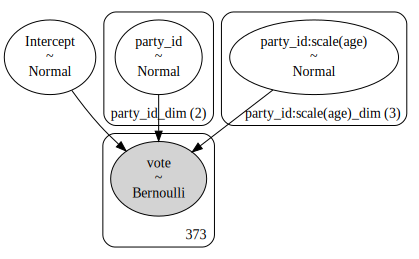

In [86]:
model_age_interaction.graph()

You can see that on the top right with dim(3) indicating we now have 3 extra covariates in our model

## Run our MCMC Sampler

In [74]:
idata_age_interaction = model_age_interaction.fit(chains=4, draws=2000, tune=2000)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, party_id, party_id:scale(age)]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.


## Our age  estimates

In [76]:
az.summary(idata_age_interaction, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,2.308,0.270,1.803,2.821
party_id[independent],-2.555,0.334,-3.136,-1.877
party_id[republican],-5.726,0.786,-7.267,-4.394
party_id:scale(age)[democrat],0.215,0.261,-0.283,0.699
party_id:scale(age)[independent],-0.579,0.203,-0.965,-0.210
party_id:scale(age)[republican],-1.434,0.691,-2.769,-0.245


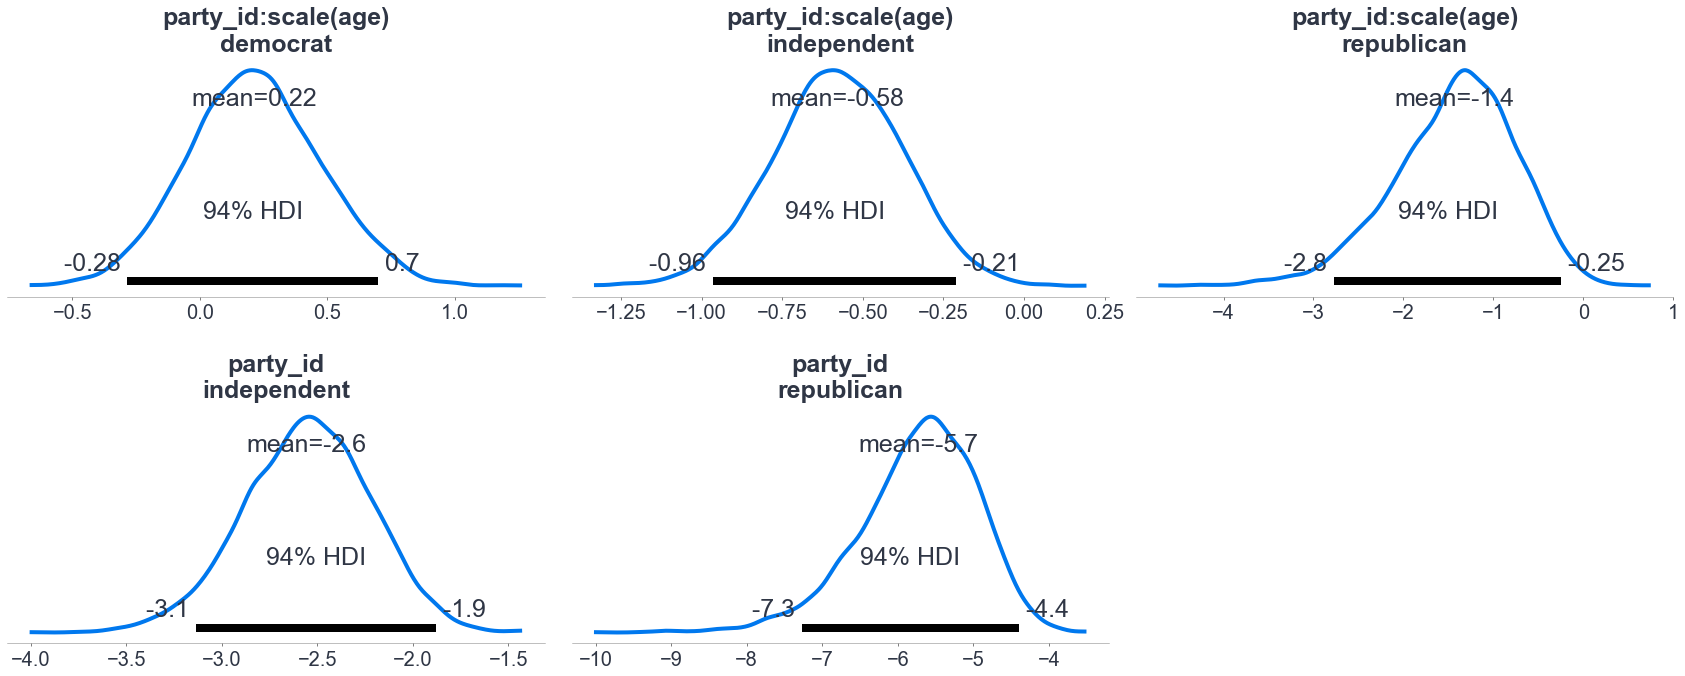

In [77]:
az.plot_posterior(
    idata_age_interaction,
    var_names=["party_id:scale(age)", "party_id"],
    figsize=(24, 10),
    backend_kwargs={"tight_layout": True}
);

Now we can again see 3 variables for each our interactions. Lets make the same plot again

## Plotting our age interaction

In [78]:
# Predict mean of P(vote = clinton | age) by plugging in new data
model_age.predict(inf_data_age, data=new_data)

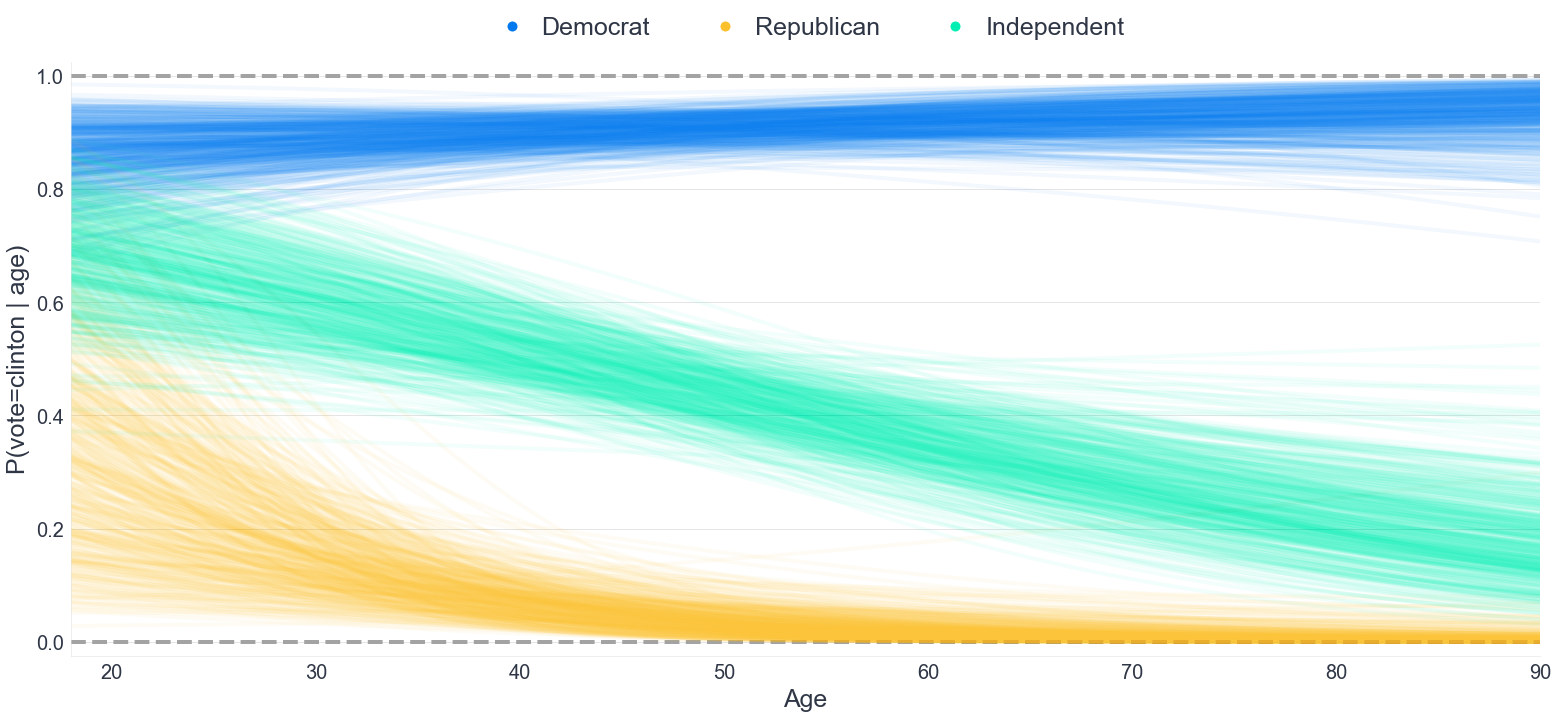

In [79]:
fig, ax = plt.subplots(figsize=(24, 10))
model_age_interaction.predict(idata_age_interaction, data=new_data)
vote_mean = az.extract_dataset(idata_age_interaction.posterior, num_samples=500)["vote_mean"]
plot_vote_predictions(vote_mean, ax=ax)

Now we see something different! As people who identify with a party age they tend to **generally** be more sure of their candidate. With Republican voters the trend is clear, they vote for Trump. For democrat voters they tend to vote for Clinton more on average, but it seems there is a but more uncertainary

And on the young end we see even more variability for republican voters than we did in the previous graph.

Which regression is right? They both are! One represents age on average, the previous one. And this one tells the story of age once we control for party preference. 

## Section Recap
* Logistic Regression can help us understand voter preferences
* Interaction effects help us answer different questions
  * How does propensity to vote for one candidate or another?
  * How does it change per subgroup?
* Plotting many posterior predictive samples helps us understand variability

# Lesson Recap

## Bayesian AB Test
* Determined that people who like videogames tend to purchase more
* Used a classic distribution AB test to assess this
* Was unable assess the affect of age however

## ABDCE Test
* Tried extended the AB testing framework to age using derived categorization
  * Managed to include age but not well as we'd like
* Tried to use a Bayesian linear regression to include effect of age
  * Our MCMC sampler failed suggesting there were model issues
* Used Ordinary Least Squares to estimate effect of age
  * We got a slope which is great
  * The probabilities suggested were wrong though which is bad

## Link Functions
* Link functions take a linear output and transform it into a different space
  * **This is a key concept for this course**
* Introduced Sigmoid function
  * Converts $(-\infty, \infty)$ output to $(0,1)$
  * This is perfect for probability
* Fitted a model in both PyMC and Bambi with age
  * We got our result!

## End to End Analysis with Bambi
* Used Bambi to include both covariates
* Able to plot results showing curves for age and by group
* Given age and preference we could predict propensity to convert

## Modeling U.S.A Election Preferences
* Modeled **actual** voter preferences for 2016 election
* Included age and party preference to understand how peoples votes changed as  function of both
* Controlled for age and `age|party` which helped us make two conclusions
  * Older people got the greater their tendency to vote for Trump if we didn't know their party
  * If we did control for party, older folks stayed more consistent with party lines

# Appendix Section: Binomial Model
Reviewer's note: This section would be recorded
If we'd rather prefer binomial heres how todo it.

## DataFrame at individual level

In [80]:
df

,age,likes_videogames,likes_videogames_bool,p_convert,converted_bool,converted
259,18.0,Yes,1,0.771863,0,No
175,18.0,Yes,1,0.764981,1,Yes
96,18.0,No,0,0.330940,0,No
987,18.0,Yes,1,0.771312,1,Yes
480,18.0,No,0,0.293105,0,No
...,...,...,...,...,...,...
249,59.0,Yes,1,0.068011,0,No
230,59.0,No,0,0.006820,0,No
926,59.0,Yes,1,0.063477,0,No
981,59.0,Yes,1,0.047442,0,No


## Aggregate to (Converted, Count)

In [81]:
binom_df = (
    df.groupby(["likes_videogames", "age"])
    .agg(Converted=("converted_bool", sum), Count=("converted_bool", len))
    .reset_index()
)
binom_df

,likes_videogames,age,Converted,Count
0,No,18.0,2,10
1,No,19.0,1,8
2,No,20.0,6,11
3,No,21.0,1,10
4,No,22.0,3,11
...,...,...,...,...
79,Yes,55.0,2,10
80,Yes,56.0,1,7
81,Yes,57.0,0,11
82,Yes,58.0,0,12


In [82]:
conversion_model = bmb.Model(
    "p(Converted, Count) ~ likes_videogames + age", binom_df, family="binomial"
)
conversion_model_fitted = conversion_model.fit(draws=2000, target_accept=0.85, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, likes_videogames, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


In [83]:
az.summary(conversion_model_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.491,0.315,0.930,2.120,0.004,0.003,7512.0,5738.0,1.0
likes_videogames[Yes],1.782,0.201,1.392,2.154,0.003,0.002,4922.0,5458.0,1.0
age,-0.109,0.009,-0.126,-0.091,0.000,0.000,4189.0,4690.0,1.0


In [84]:
conversion_model = bmb.Model(
    "p(Converted, Count) ~ likes_videogames + age", binom_df, family="binomial"
)
conversion_model_fitted = conversion_model.fit(draws=2000, target_accept=0.85, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, likes_videogames, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
